In [93]:
from bs4 import BeautifulSoup
import requests
import re
import seaborn as sns
import pandas as pd
import numpy as np
import os
from prophet import Prophet
import json
import urllib.request
from sklearn.metrics import r2_score

In [2]:
# class YoutubeChannel():
#     def __init__(self,ChannelUrl):
#         self.dailySubscribers = allData[["Date","DailySubscribers"]]
#         self.totalSubscribers = allData[["Date","TotalSubscribers"]]
#         self.dailyVideoViews = allData[["Date","DailyVideoViews"]]
#         self.totalVideoViews = allData[["Date","TotalVideoViews"]]
#         self.allData = getAllCharts()

In [3]:
links = ["https://web.archive.org/web/20190524171902/https://socialblade.com/youtube/user/mmoshaya/monthly",
        "https://web.archive.org/web/20190524075036/https://socialblade.com/youtube/user/arabgamesnetwork/monthly",
         "https://web.archive.org/web/20190830014628/https://socialblade.com/youtube/channel/UCBzrJ1zGf9-0cd5-n7sBraQ/monthly",
        "https://web.archive.org/web/20190524134324/https://socialblade.com/youtube/channel/UCqJNTGwKmgMCwfYDbnz514Q/monthly",
        "https://web.archive.org/web/20190525094206/https://socialblade.com/youtube/user/banderitax/monthly",
        "https://web.archive.org/web/20190830022605/https://socialblade.com/youtube/channel/UCPvLEc3la6Q2MdlCXzKRRPg/monthly"]

In [4]:
# save req to html file if not found
for i in range(len(links)):
    if f"req{i}.html" not in os.listdir('.'):
        open("req"+str(i)+".html","w",encoding="UTF-8").write(requests.get(links[i]).text)

In [5]:
# read files from  disk - files name: req0.html .... req4.html
resText = [open("req"+str(i)+".html","r",encoding="UTF-8").read() for i in range(len(links))]

In [6]:
def getChartData(soup,chart_name):
    ds_element = soup.find("div",{"id":chart_name}).next_element.next_element.text
    regex = "[0-9]+-[0-9]+-[0-9]+,[0-9]+"
    dailySub = [i.split(",") for i in re.findall(regex,ds_element)]
    Date = pd.Series([i[0] for i in dailySub])
    count = pd.Series([i[1] for i in dailySub])
    return pd.DataFrame({
        "Date":Date.astype(np.datetime64),
        chart_name:count.astype(np.int64)
        })

In [7]:
def getDailySubscribers(soup):
    '''
    return dataframe contains date and dailySubscribers for the given soup
    '''
    return getChartData(soup,"DailySubscribers")

In [8]:
def getTotalSubscribers(soup):
    '''
    return dataframe contains date and totalSubscribers for the given soup
    '''
    return getChartData(soup,"TotalSubscribers")

In [9]:
def getDailyVideoViews(soup):
    '''
    return dataframe contains date and dailyVideoViews for the given soup
    '''
    return getChartData(soup,"DailyVideoViews")

In [10]:
def getTotalVideoViews(soup):
    '''
    return dataframe contains date and totalVideoViews for the given soup
    '''
    return getChartData(soup,"TotalVideoViews")

In [11]:
def getAllCharts(soup):
    '''
    return dataframe contains date, dailySubscribers, totalSubscribers, dailyVideoViews and totalVideoViews for the given soup
    '''
    ds = getDailySubscribers(soup)
    ts = getTotalSubscribers(soup)
    dv = getDailyVideoViews(soup)
    tv = getTotalVideoViews(soup)
    return ds.merge(ts,on="Date").merge(dv,on="Date").merge(tv,on="Date")

In [12]:
soups = [BeautifulSoup(r,"html5lib") for r in resText]

In [13]:
channels_df = [getAllCharts(soup) for soup in soups]

In [14]:
top1_df = channels_df[0] # top 1 channel df
top2_df = channels_df[1] # top 2 channel df
top3_df = channels_df[2] # top 3 channel df
# top4_df = channels_df[3] # top 4 channel df شلناها لان عدد الروز قليل
top4_df = channels_df[4] # top 4 channel df
top5_df = channels_df[5] # top 4 channel df

In [15]:
X_y = top1_df[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
X_y.columns = ["ds","y"]
m = Prophet(daily_seasonality=True)
m.fit(X_y)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [16]:
future = m.make_future_dataframe(periods=365)

In [17]:
forecast = m.predict(future)

In [18]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1446,2020-05-18,1.792334e+07,1.563786e+07,2.046732e+07
1447,2020-05-19,1.794252e+07,1.563131e+07,2.049004e+07
1448,2020-05-20,1.796168e+07,1.563184e+07,2.052539e+07
1449,2020-05-21,1.798074e+07,1.565507e+07,2.054376e+07
1450,2020-05-22,1.800025e+07,1.565633e+07,2.058236e+07


In [19]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1446,2020-05-18,1.792334e+07,1.563786e+07,2.046732e+07
1447,2020-05-19,1.794252e+07,1.563131e+07,2.049004e+07
1448,2020-05-20,1.796168e+07,1.563184e+07,2.052539e+07
1449,2020-05-21,1.798074e+07,1.565507e+07,2.054376e+07
1450,2020-05-22,1.800025e+07,1.565633e+07,2.058236e+07


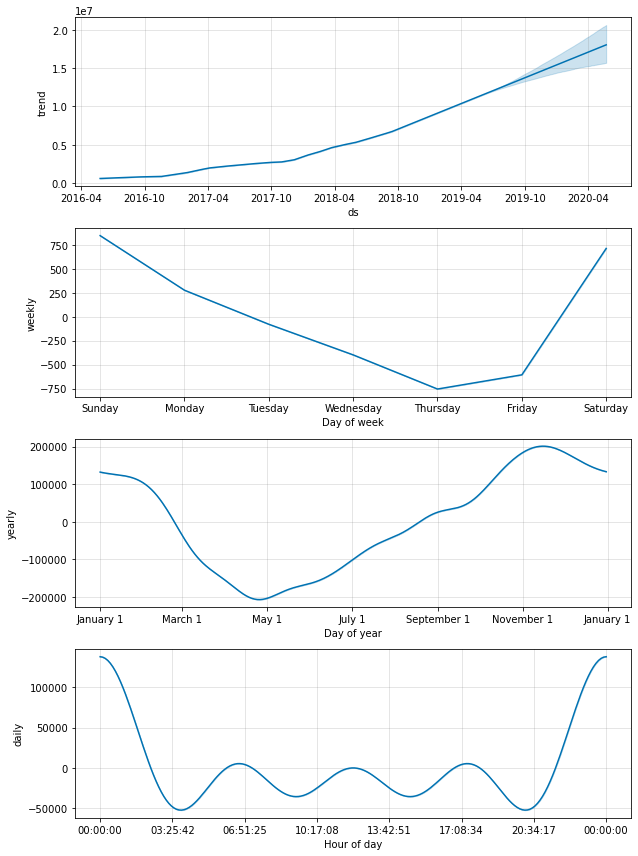

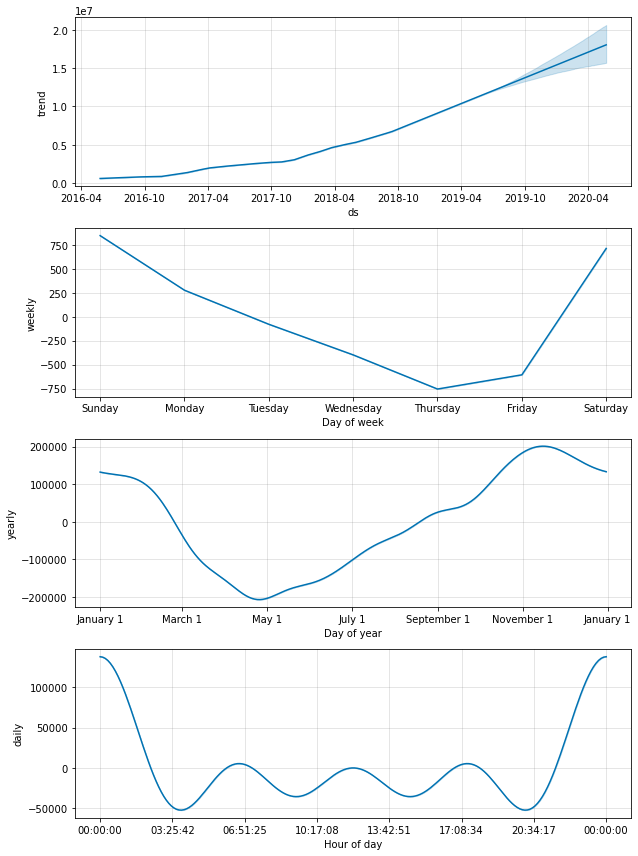

In [20]:
 m.plot_components(forecast)

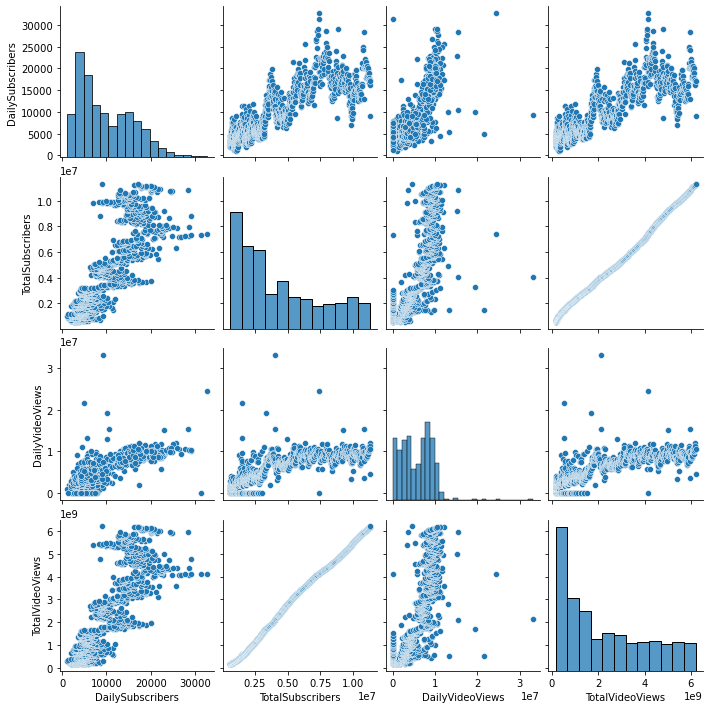

In [47]:
sns.pairplot(top1_df)

In [49]:
# total number of rows
# total = 0
# for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
#     total += len(c)
# print(f"the total number of rows is {total}")

In [50]:
# for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
#     print(c.info())

In [70]:
def getAllCharts_newlinks(url):
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    response = str(opener.open(url).read())
    allCharts = [json.loads(l[0]) for l in re.findall('(\[(\[\d+,\d+\],?)+\])',response)]
    col = re.findall('title: { text: \\\\\'([\w|\s]+) for',response)
    date1 = pd.Series([i[0] for i in lists[0]])
    weeklyGainedSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date1,unit="ms"),#.dt.date, #parse Date from timestamp to date
        col[0]: [i[1] for i in lists[0]],
        col[1]: [i[1] for i in lists[1]],
    })

    date2 = pd.Series([i[0] for i in lists[2]])
    monthlyTotoalSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date2,unit="ms"),#.dt.date, #parse Date from timestamp to date
        "TotalSubscribers": [i[1] for i in lists[2]],
        "TotalVideoViews": [i[1] for i in lists[3]],
    })

    date3 = pd.Series([i[0] for i in lists[4]])
    weeklyTotoalSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date3,unit="ms"),#.dt.date, #parse Date from timestamp to date
        "TotalSubscribers": [i[1] for i in lists[4]],
        "TotalVideoViews": [i[1] for i in lists[5]],
    })
    return [weeklyGainedSubsAndViews,monthlyTotoalSubsAndViews,weeklyTotoalSubsAndViews]

In [71]:
top1 = getAllCharts_newlinks("https://socialblade.com/youtube/user/mmoshaya/monthly")

In [74]:
top1_m = pd.concat([top1_df[["Date","TotalSubscribers","TotalVideoViews"]],top1[1],top1[2]])

In [87]:
X_y = top1_m[["Date","TotalVideoViews"]]#[top1_df["DailyVideoViews"] != 0]
X_y.columns = ["ds","y"]
md = Prophet()
md.fit(X_y)

In [88]:
future = md.make_future_dataframe(periods=365)

In [89]:
future

,ds
0,2016-05-26 00:00:00
1,2016-05-27 00:00:00
2,2016-05-28 00:00:00
3,2016-05-29 00:00:00
4,2016-05-30 00:00:00
...,...
1530,2022-09-16 04:00:00
1531,2022-09-17 04:00:00
1532,2022-09-18 04:00:00
1533,2022-09-19 04:00:00


In [90]:
forecast = md.predict(future)

In [91]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1530,2022-09-16 04:00:00,1.816333e+10,1.755824e+10,1.883464e+10
1531,2022-09-17 04:00:00,1.817382e+10,1.755894e+10,1.885438e+10
1532,2022-09-18 04:00:00,1.818173e+10,1.755353e+10,1.884076e+10
1533,2022-09-19 04:00:00,1.819237e+10,1.758504e+10,1.887195e+10
1534,2022-09-20 04:00:00,1.820486e+10,1.758346e+10,1.888672e+10


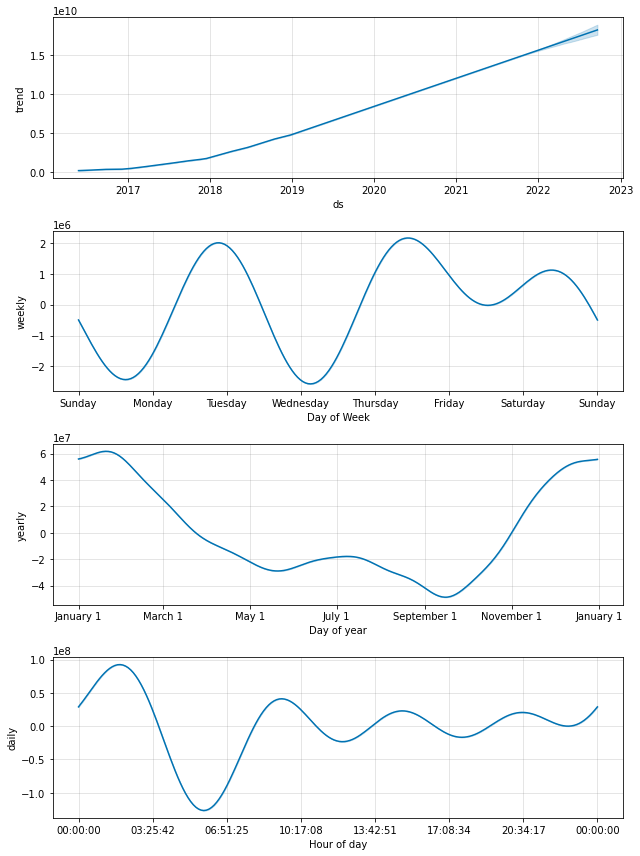

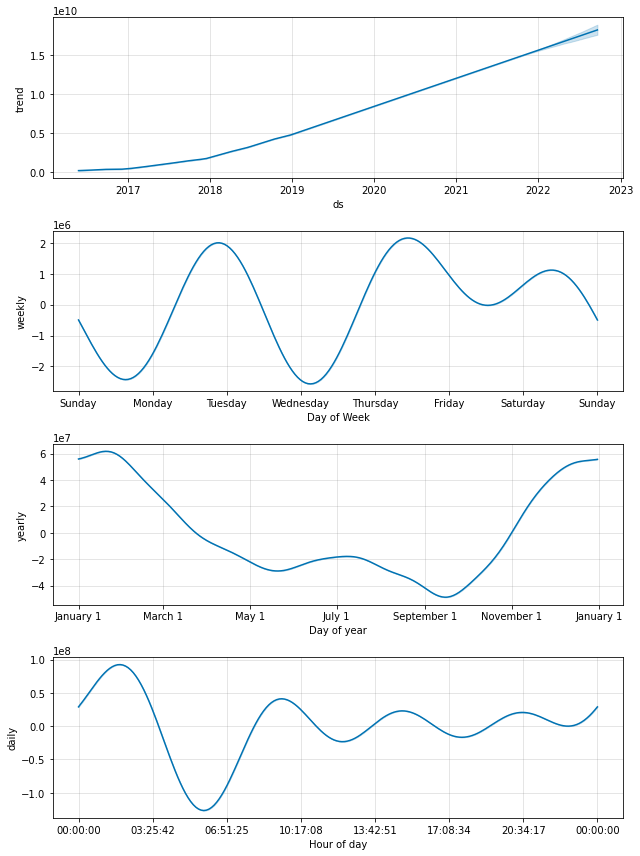

In [92]:
 md.plot_components(forecast)

In [102]:
y_yhat = top1_m.merge(forecast[["ds","yhat"]],left_on="Date",right_on="ds")
r2_score(y_yhat["TotalVideoViews"],y_yhat["yhat"])

0.9999453474916665

In [33]:
r2_score()

In [44]:
df1[(df1["Weekly Subscribers Gained"] == 100000)]

,Date,Weekly Subscribers Gained,Weekly Video Views Gained
53,2019-09-23,100000,52901676
54,2019-09-30,100000,38760077
56,2019-10-14,100000,49344701
57,2019-10-21,100000,49455309
58,2019-10-28,100000,48391676
...,...,...,...
144,2021-06-21,100000,59064810
146,2021-07-05,100000,56171040
148,2021-07-19,100000,51265550
151,2021-08-09,100000,55647911


# needs to check it 


In [ ]:
with open('req0.html') as page:
    html = page.read()
soup = BeautifulSoup(html, 'lxml')

In [ ]:
#print(soup.prettify())

In [ ]:
# up_string = soup.find_all(text=re.compile('Up'))
# up_string

In [ ]:
# rows = [row for row in soup.find_all("span",class_="YouTubeUserTopLight")]
# rows

In [ ]:
# soup.find_all("span",class_="YouTubeUserTopLight")[0].text

In [ ]:
# rows = [row for row in soup.find_all("span",style="font-weight: bold;")] 
# rows[0:6]

In [ ]:
list_columns=[]
for i in soup.find_all("span",class_="YouTubeUserTopLight"):
        list_columns.append(i.get_text())
print(list_columns)

In [ ]:
list_req0=[]
for i in soup.find_all("span",style="font-weight: bold;"):
        list_req0.append(i.get_text())
print(list_req0)